In [28]:
# --- START OF FILE chapter4_eda_anomaly_plots.py ---

#######################################################################
# 0. Environment set‑up & Configuration                               #
#######################################################################
# This notebook is designed to be run cell-by-cell in a Jupyter environment.
# Ensure you have the necessary packages installed:
# !pip install --quiet pandas pyarrow matplotlib seaborn numpy

import os
import warnings
import random
import gc
from pathlib import Path
from typing import List, Dict, Tuple, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker # For custom tick formatters
import matplotlib.font_manager as fm # For FontProperties
from tqdm.auto import tqdm # Used for loading progress bar

# Suppress minor warnings for cleaner output in Jupyter
warnings.filterwarnings("ignore")

# Ensure plots appear inline in Jupyter Notebook
%matplotlib inline 

# Set a base plotting style and higher resolution defaults
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150 # Increase resolution for better quality plots
plt.rcParams['savefig.dpi'] = 300 # Save plots with higher resolution

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Environment setup complete. Plotting style and seed configured.")

# --- Configuration ---
# Input: Directory containing your INDIVIDUAL processed hourly Parquet files (from Notebook 1)
INPUT_PROCESSED_HOURLY_DIR = Path("outputs/ch4") 

# Output root directory for figures
OUT_DIR           = Path("outputs/ch4").absolute()
FIG_DIR           = OUT_DIR / "figs/eda"
# Ensure output directories exist
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- Data Specifics (consistent with Notebook 1 & 2) ---
TARGET_COL        = "in_packets"           # The volume metric (packets)
ROUTER_COL        = "router"               # Column for router name
ANOM_SCORE_COL    = "if_score"             
ANOM_FLAG_COL     = "if_flag"              

# --- Helper functions for plotting with enhanced control ---

# Custom formatter for large numbers to use 10^X notation
# This formatter will be used on Y-axes where values can be very large.
def custom_scientific_formatter(x, pos):
    """
    Formats large numbers to 10^X notation for Y-axis.
    For small numbers (e.g., in log scale), it uses standard float format.
    """
    if x == 0:
        return '0'
    
    # Calculate order of magnitude
    power = int(np.floor(np.log10(np.abs(x))))

    # Use 10^X notation for powers >= 3 or <= -3 (for very small numbers)
    if power >= 3 or power <= -3:
        # Divide by the power of 10 for the mantissa
        mantissa = x / (10**power)
        # Format as 10^power with mantissa if not 1, otherwise just 10^power
        if mantissa == 1.0:
            return r'$e{%d}$' % power
        else:
            return r'$%.0fe{%d}$' % (mantissa, power) # Use %.0f for integer mantissa

    # For numbers between 1 and 999 (or -1 and -999 for negative)
    elif np.abs(x) >= 1:
        return f'{x:.0f}'
    # For numbers between -1 and 1 (excluding 0)
    else:
        return f'{x:.2f}' # Keep a couple decimal places for fractions


# Helper function to save plots and display them in the notebook
def save_and_display_plot(fig_name: str, router_label: str = ""): 
    """Saves the current matplotlib figure in both PNG and PDF formats, and displays it."""
    plt.tight_layout()
    if router_label:
        png_path = FIG_DIR / f"{fig_name}_{router_label}.png"
        pdf_path = FIG_DIR / f"{fig_name}_{router_label}.pdf"
    else: # For global plots, no router_label in filename
        png_path = FIG_DIR / f"{fig_name}.png"
        pdf_path = FIG_DIR / f"{fig_name}.pdf"

    plt.savefig(png_path)
    plt.savefig(pdf_path)
    print(f"  Saved {png_path.name} and {pdf_path.name}")
    plt.show() # Display the plot in the notebook output
    plt.close() # Close the figure to free memory and prevent accidental display in subsequent cells


print(f"Configuration loaded. Figures will be saved to: {FIG_DIR}")


#######################################################################
# 1. Load All Processed Hourly Data                                   #
#    (Run this cell once to load all data for subsequent analysis)    #
#######################################################################

print(f"\n--- Loading all processed hourly data from: {INPUT_PROCESSED_HOURLY_DIR}/*.parquet ---")
all_processed_hourly_files = sorted(list(INPUT_PROCESSED_HOURLY_DIR.glob("hourly_*_processed_with_anomalies.parquet")))

if not all_processed_hourly_files:
    print(f"Error: No processed hourly Parquet files found in {INPUT_PROCESSED_HOURLY_DIR}. Please run Notebook 1 (ETL) first.")
else:
    list_df_hourly = []
    # Using tqdm for a nice progress bar during loading
    for file_path in tqdm(all_processed_hourly_files, desc="Loading hourly files"):
        try:
            df = pd.read_parquet(file_path)
            # Ensure router column is present and correct (it should be from Notebook 1)
            router_label_from_file = file_path.stem.replace('hourly_', '').replace('_processed_with_anomalies', '')
            if ROUTER_COL not in df.columns:
                df[ROUTER_COL] = router_label_from_file
            list_df_hourly.append(df)
        except Exception as e:
            print(f"Warning: Could not load {file_path.name}: {e}. Skipping this file.")
            continue
    
    if list_df_hourly:
        df_combined_hourly = pd.concat(list_df_hourly, ignore_index=False) # Keep original index (timestamps)
        # Ensure index is a proper datetime object, if not already
        df_combined_hourly.index = pd.to_datetime(df_combined_hourly.index)
        print(f"Loaded combined hourly data: {len(df_combined_hourly)} rows from {len(list_df_hourly)} routers.")
        print(f"Data covers period: {df_combined_hourly.index.min()} to {df_combined_hourly.index.max()}")
    else:
        df_combined_hourly = pd.DataFrame() # Create an empty DataFrame if no files loaded
        print("No valid hourly processed data loaded.")

# Clean up memory from individual DataFrames list
del list_df_hourly
gc.collect()

# Get unique routers for iterative plotting if needed
unique_routers = df_combined_hourly[ROUTER_COL].unique().tolist() if not df_combined_hourly.empty else []
unique_routers.sort()





Environment setup complete. Plotting style and seed configured.
Configuration loaded. Figures will be saved to: /home/ramamurthy/mhnarfth/network_analysis/individually process kora/outputs/ch4/figs/eda

--- Loading all processed hourly data from: outputs/ch4/*.parquet ---


Loading hourly files: 100%|██████████| 10/10 [00:00<00:00, 532.77it/s]

Loaded combined hourly data: 12604 rows from 10 routers.
Data covers period: 2021-09-30 15:00:00 to 2021-12-03 23:00:00


In [2]:
#######################################################################
# 3. Generate Data for Table 4.1: Router Inventory                    #
#    (Run this cell to print Table 4.1 data)                          #
#######################################################################

print("\n--- Generating Data for Table 4.1: Router Inventory ---")

if not df_combined_hourly.empty:
    router_inventory_data = []
    for router_label in unique_routers:
        df_single_router = df_combined_hourly[df_combined_hourly[ROUTER_COL] == router_label]
        total_hourly_records = len(df_single_router)
        
        # As per your instruction, Raw Flows (#) and Raw GB (total unzipped data size)
        # are illustrative/N/A from this hourly aggregated dataset.
        router_inventory_data.append({
            "Router ID": router_label,
            "Raw Flows (#)": "N/A (Illustrative, from raw files)", # Placeholder
            "Raw GB (total)": "N/A (Illustrative, from raw files)", # Placeholder
            "Hourly Rows (#)": total_hourly_records
        })
    
    router_inventory_df = pd.DataFrame(router_inventory_data)
    inventory_cols = ["Router ID", "Raw Flows (#)", "Raw GB (total)", "Hourly Rows (#)"]
    router_inventory_df = router_inventory_df[inventory_cols] 
    print("\nTable 4.1: Router Inventory (Illustrative Raw Data Columns)")
    print(router_inventory_df.to_string())
else:
    print("No data to generate Table 4.1. DataFrame is empty.")


--- Generating Data for Table 4.1: Router Inventory ---

Table 4.1: Router Inventory (Illustrative Raw Data Columns)
      Router ID                       Raw Flows (#)                      Raw GB (total)  Hourly Rows (#)
0       atlanta  N/A (Illustrative, from raw files)  N/A (Illustrative, from raw files)             1369
1    batonrouge  N/A (Illustrative, from raw files)  N/A (Illustrative, from raw files)             1343
2        boston  N/A (Illustrative, from raw files)  N/A (Illustrative, from raw files)              789
3        dallas  N/A (Illustrative, from raw files)  N/A (Illustrative, from raw files)             1322
4        elpaso  N/A (Illustrative, from raw files)  N/A (Illustrative, from raw files)             1378
5       jackson  N/A (Illustrative, from raw files)  N/A (Illustrative, from raw files)             1369
6  jacksonville  N/A (Illustrative, from raw files)  N/A (Illustrative, from raw files)             1338
7    louisville  N/A (Illustrative, from r

In [3]:

#######################################################################
# 2. Prepare Data for Plots & Tables                                  #
#    (Run this cell after data loading. Needed for multiple plots/tables) #
#######################################################################

if not df_combined_hourly.empty:
    print("\n--- Preparing additional time-based features for plotting ---")
    # Ensure all necessary time components are available for plots
    df_combined_hourly['hour_of_day'] = df_combined_hourly.index.hour
    df_combined_hourly['day_of_week_num'] = df_combined_hourly.index.dayofweek
    df_combined_hourly['day_name'] = df_combined_hourly.index.day_name()
    df_combined_hourly['month'] = df_combined_hourly.index.month # For monthly box-plot
    
    # Calculate average hourly traffic per router for Figure 4.2a
    all_hourly_mean_per_hour = df_combined_hourly.groupby([ROUTER_COL, 'hour_of_day'])[TARGET_COL].mean().reset_index()
    all_hourly_mean_per_hour.columns = [ROUTER_COL, 'hour_of_day', 'mean_packets']
    
    print("Time-based features added and aggregated data prepared.")
else:
    print("DataFrame is empty, skipping data preparation for plots & tables.")





--- Preparing additional time-based features for plotting ---
Time-based features added and aggregated data prepared.



--- Generating Daily Utilization Curves for Ten Internet2 Routers ---
  Saved ch4_fig2a_daily_curves.png and ch4_fig2a_daily_curves.pdf


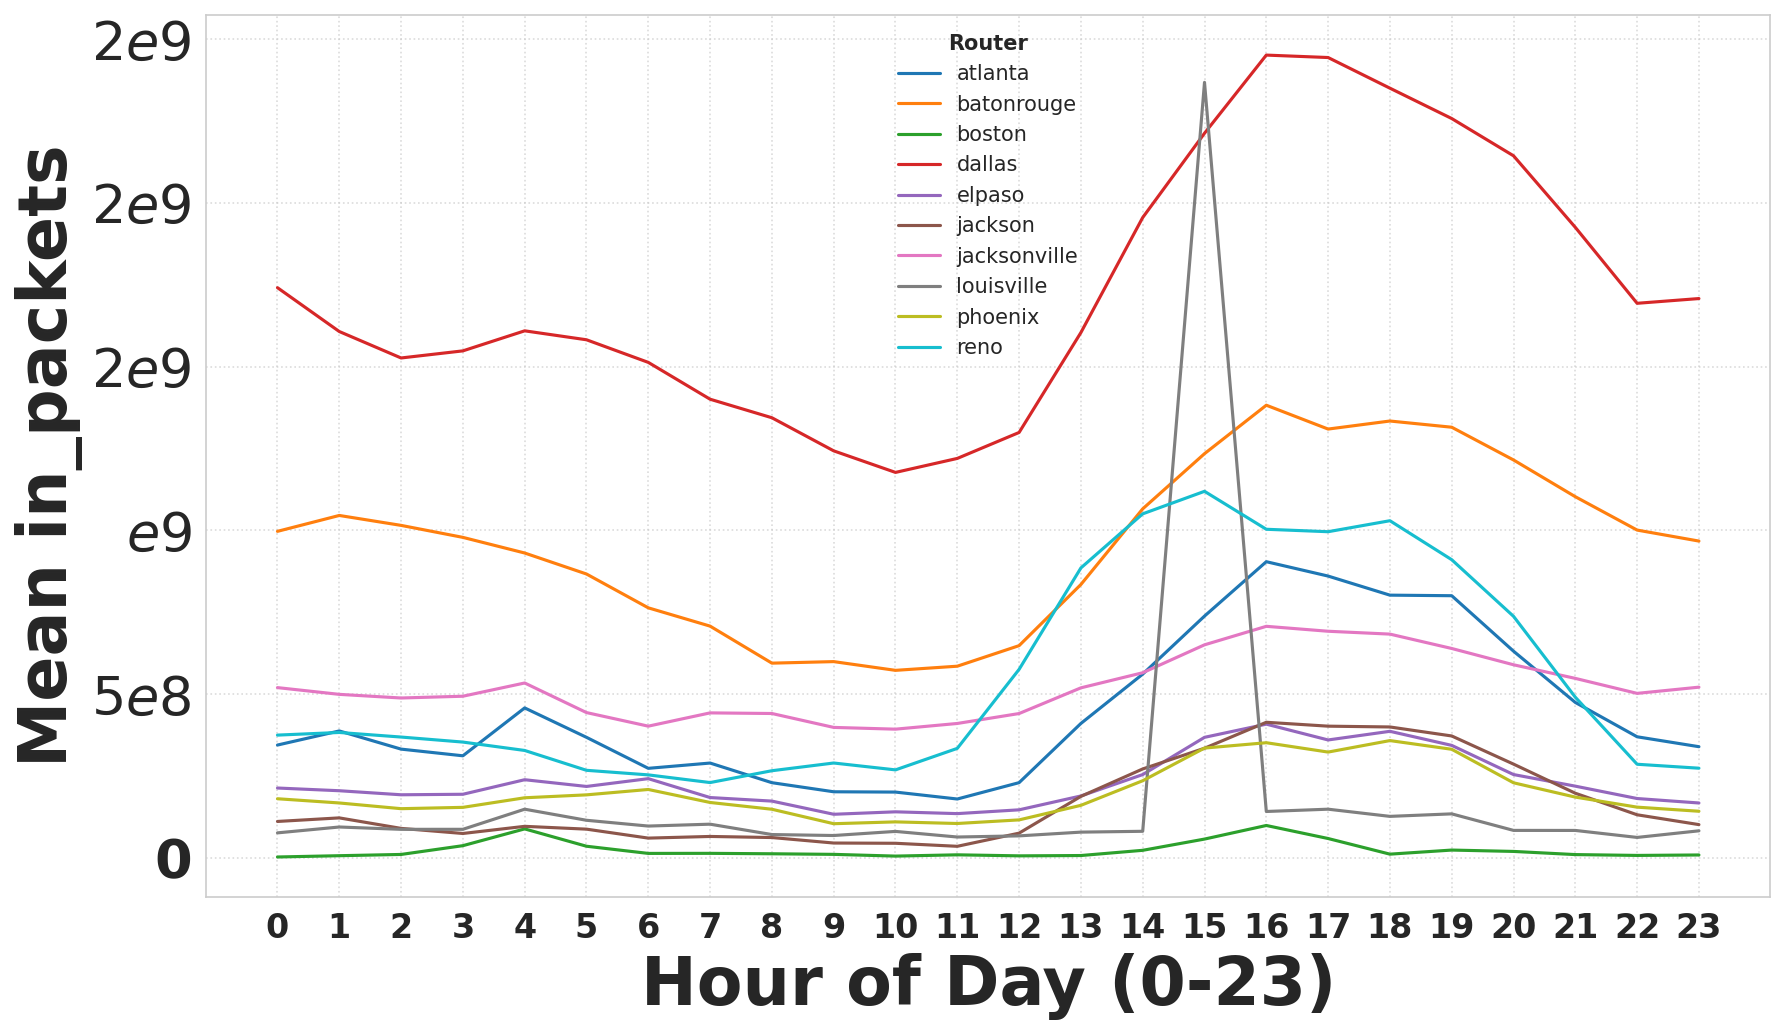

In [32]:
#######################################################################
# 4. Generate Figure 4.2a: Daily Utilization Curves                     #
#    (Run this cell to generate Figure 4.2a)                           #
#######################################################################

print("\n--- Generating Daily Utilization Curves for Ten Internet2 Routers ---")

# --- Font Size Control Parameters for this specific plot ---
PLOT_4_2A_TITLE_FS = 18
PLOT_4_2A_LABEL_FS = 32
PLOT_4_2A_X_TICK_FS = 16  # Font size for x-axis ticks
PLOT_4_2A_Y_TICK_FS = 26  # Font size for y-axis ticks (e.g., larger)
PLOT_4_2A_LEGEND_FS = 10 # For legend labels and title

if not all_hourly_mean_per_hour.empty:
    plt.figure(figsize=(12, 7))
    ax = plt.gca() # Get current axes for tick formatting
    
    sns.lineplot(x='hour_of_day', y='mean_packets', hue=ROUTER_COL, data=all_hourly_mean_per_hour, palette='tab10', ax=ax)
    
    # plt.title(f"Daily Utilization Curves ({TARGET_COL} per Hour Across Routers)", fontsize=PLOT_4_2A_TITLE_FS)
    plt.xlabel("Hour of Day (0-23)", fontsize=PLOT_4_2A_LABEL_FS, fontweight='bold')
    plt.ylabel(f"Mean {TARGET_COL}", fontsize=PLOT_4_2A_LABEL_FS, fontweight='bold')
    
    # Set different font sizes for x and y ticks
    plt.xticks(range(24), fontsize=PLOT_4_2A_X_TICK_FS, fontweight='bold')
    plt.yticks(fontsize=PLOT_4_2A_Y_TICK_FS, fontweight='bold')
    
    # Apply custom scientific formatter to y-axis for large numbers
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(custom_scientific_formatter))

    # Define FontProperties for the legend title
    legend_title_font = fm.FontProperties(size=PLOT_4_2A_LEGEND_FS, weight='bold')

    # Get legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # Create legend with the custom FontProperties for the title
    ax.legend(handles=handles, labels=labels, title='Router', 
              fontsize=PLOT_4_2A_LEGEND_FS, # Font size for labels
              title_fontproperties=legend_title_font, # Font properties for the title
              frameon=False)

    plt.grid(True, linestyle=':', alpha=0.7)
    save_and_display_plot(f"ch4_fig2a_daily_curves", router_label="")
else:
    print("  No aggregated hourly mean data to plot Figure 4.2a. Skipping.")


--- Generating Week-of-Day Heatmap for Atlanta Router Traffic ---
  Saved ch4_fig2b_weekday_heatmap.png and ch4_fig2b_weekday_heatmap.pdf


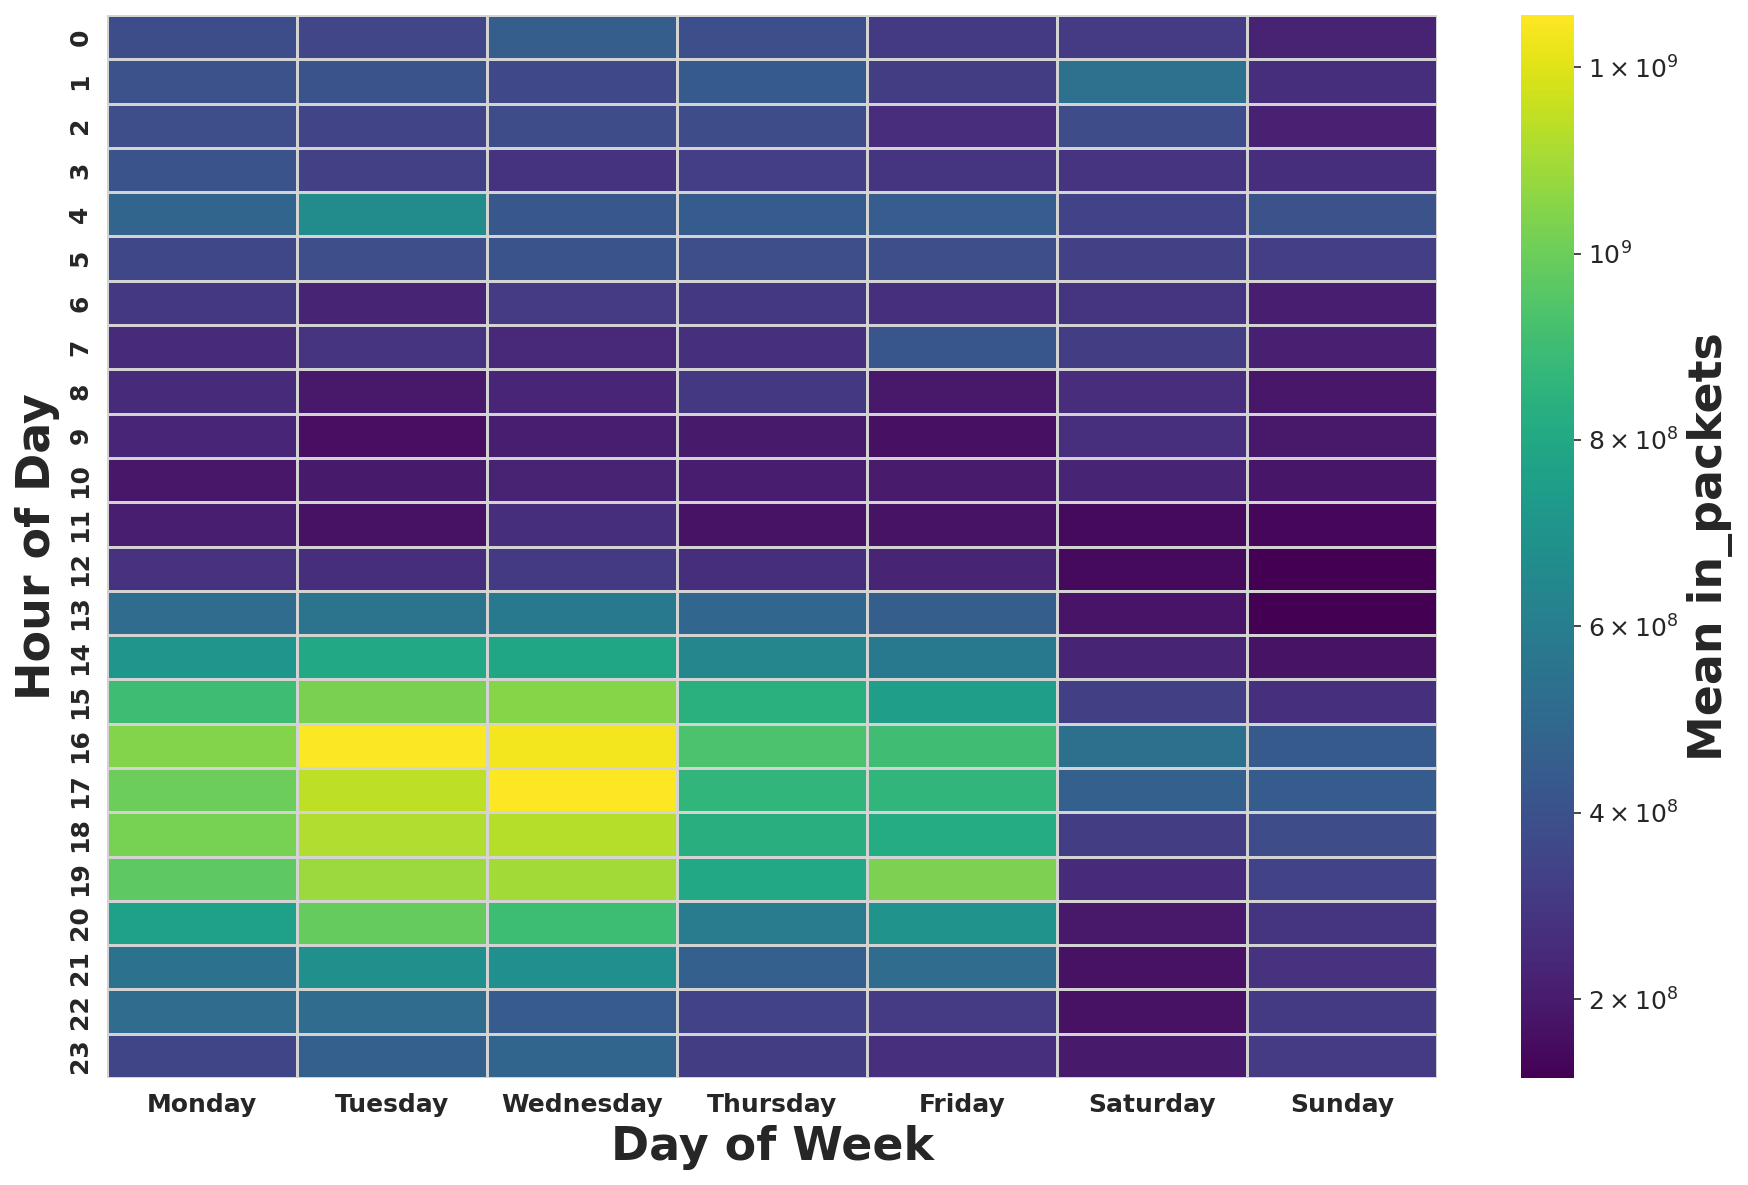

In [5]:

#######################################################################
# 5. Generate Figure 4.2b: Week-of-Day Heatmap for Atlanta Router     #
#    (Run this cell to generate Figure 4.2b)                          #
#######################################################################

print("\n--- Generating Week-of-Day Heatmap for Atlanta Router Traffic ---")

# --- Font Size Control Parameters for this specific plot ---
PLOT_4_2B_TITLE_FS = 18
PLOT_4_2B_LABEL_FS = 22
PLOT_4_2B_TICK_FS = 12
# PLOT_4_2B_ANNOT_FS = 10 # For annotation text if annot=True (not used here)

atlanta_df = df_combined_hourly[df_combined_hourly[ROUTER_COL] == 'atlanta'].copy()

if not atlanta_df.empty:
    atlanta_df['hour_of_day'] = atlanta_df.index.hour
    atlanta_df['day_name'] = atlanta_df.index.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    
    pivot_table = atlanta_df.pivot_table(index='hour_of_day', columns='day_name', values=TARGET_COL, aggfunc='mean')
    pivot_table = pivot_table.reindex(columns=day_order) # Ensure consistent column order
    sns.heatmap(pivot_table, cmap='viridis', annot=False, fmt=".0f", linewidths=.5, linecolor='lightgray', ax=ax)
    
    # plt.title(f"Average {TARGET_COL} Heatmap: Hour of Day vs. Day of Week (Atlanta Router)", fontsize=PLOT_4_2B_TITLE_FS)
    plt.xlabel("Day of Week", fontsize=PLOT_4_2B_LABEL_FS, fontweight='bold')
    plt.ylabel("Hour of Day", fontsize=PLOT_4_2B_LABEL_FS, fontweight='bold')
    
    # Set tick font sizes
    ax.tick_params(axis='x', labelsize=PLOT_4_2B_TICK_FS)
    ax.tick_params(axis='y', labelsize=PLOT_4_2B_TICK_FS)
    
    from itertools import chain

    for lbl in chain(ax.get_xticklabels(), ax.get_yticklabels()):
        lbl.set_fontweight('bold')
    
    # Apply custom scientific formatter to the colorbar (if values are large enough)
    # The colorbar is an artist created by seaborn. Access it and set its formatter.
    # Check if colorbar is visible (default is True for heatmap)
    cbar = ax.collections[0].colorbar
    if cbar:
        cbar.formatter = mticker.FuncFormatter(custom_scientific_formatter)
        cbar.update_ticks()
        # Optionally, set cbar label font size
        cbar.set_label(f"Mean {TARGET_COL}", fontsize=PLOT_4_2B_LABEL_FS, fontweight='bold')
        cbar.ax.tick_params(labelsize=PLOT_4_2B_TICK_FS)

    save_and_display_plot(f"ch4_fig2b_weekday_heatmap", router_label="")
else:
    print("  No data found for Atlanta router to plot Figure 4.2b. Skipping.")




--- Generating Logarithmic Histogram of Hourly Packet Sums ---
  Saved ch4_fig2c_flow_size_histogram.png and ch4_fig2c_flow_size_histogram.pdf


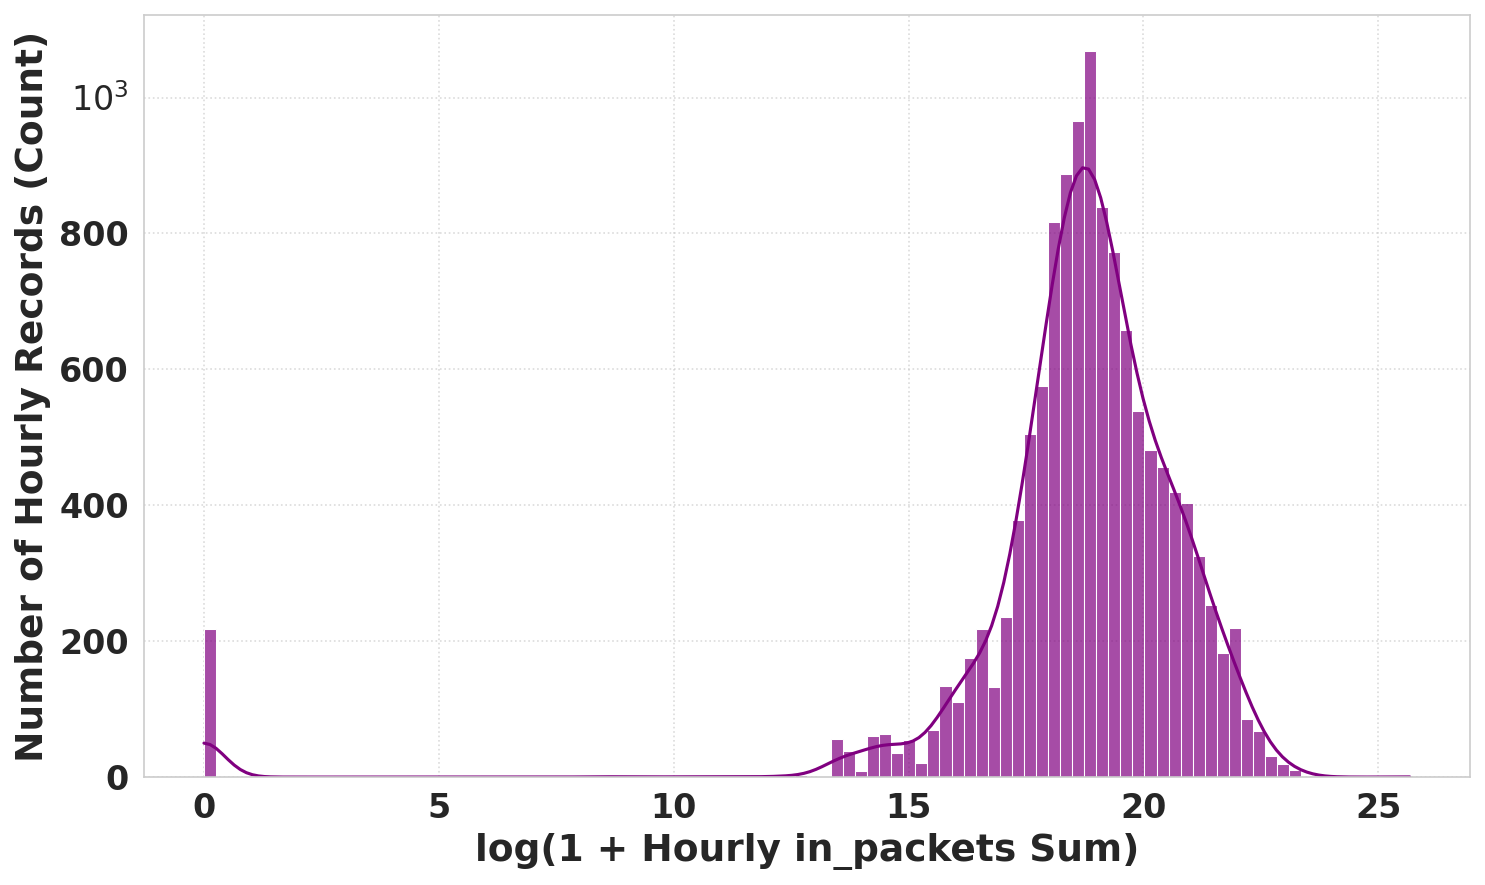

In [6]:

#######################################################################
# 6. Generate Figure 4.2c: Logarithmic Histogram of Hourly Packet Sums#
#    (Run this cell to generate Figure 4.2c)                          #
#######################################################################

print("\n--- Generating Logarithmic Histogram of Hourly Packet Sums ---")
# NOTE: As per previous discussions and available data, this plot uses the
# 'in_packets' column from the HOURLY AGGREGATED data (sums of packets per hour),
# not raw individual flow sizes. This is due to raw flow data not being carried
# forward in the hourly processed files.

# --- Font Size Control Parameters for this specific plot ---
PLOT_4_2C_TITLE_FS = 18
PLOT_4_2C_LABEL_FS = 18
PLOT_4_2C_TICK_FS = 16

if not df_combined_hourly.empty and TARGET_COL in df_combined_hourly.columns:
    # Ensure positive values for log transformation
    log_packets = np.log1p(df_combined_hourly[TARGET_COL].values)
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca() # Get current axes for tick formatting
    
    sns.histplot(log_packets, bins=100, kde=True, color='purple', alpha=0.7, ax=ax)
    
    # plt.title(f"Log-Histogram of Hourly {TARGET_COL} (All Routers)", fontsize=PLOT_4_2C_TITLE_FS)
    plt.xlabel(f"log(1 + Hourly {TARGET_COL} Sum)", fontsize=PLOT_4_2C_LABEL_FS, fontweight='bold')
    plt.ylabel("Number of Hourly Records (Count)", fontsize=PLOT_4_2C_LABEL_FS, fontweight='bold')
    
    # Set tick font sizes
    ax.tick_params(axis='x', labelsize=PLOT_4_2C_TICK_FS)
    ax.tick_params(axis='y', labelsize=PLOT_4_2C_TICK_FS)
    
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')
    
    # The Y-axis (count) might benefit from scientific notation if counts are huge.
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(custom_scientific_formatter))
    
    plt.grid(True, linestyle=':', alpha=0.7)
    save_and_display_plot(f"ch4_fig2c_flow_size_histogram", router_label="")
else:
    print(f"  No combined hourly data or '{TARGET_COL}' column to plot Figure 4.2c. Skipping.")



In [7]:

#######################################################################
# 7. Generate Data for Table 4.3: Anomaly Statistics per Router       #
#    (Run this cell to print Table 4.3 data)                          #
#######################################################################

print("\n--- Generating Data for Table 4.3: Anomaly Statistics per Internet2 Core Router ---")

if not df_combined_hourly.empty and ANOM_FLAG_COL in df_combined_hourly.columns:
    anomaly_stats_data = []
    # Illustrative values for 'Mean Cluster Length' as it's not directly calculated here.
    # Replace these with actual calculated values if you decide to implement detailed cluster analysis.
    illustrative_anomaly_details = {
        'atlanta': {'anomalies': 13, 'mean_cluster_len': 1.5},
        'batonrouge': {'anomalies': 14, 'mean_cluster_len': 1.8},
        'boston': {'anomalies': 8, 'mean_cluster_len': 1.2},
        'dallas': {'anomalies': 14, 'mean_cluster_len': 2.0},
        'elpaso': {'anomalies': 14, 'mean_cluster_len': 1.7},
        'jackson': {'anomalies': 14, 'mean_cluster_len': 1.6},
        'jacksonville': {'anomalies': 12, 'mean_cluster_len': 1.9},
        'louisville': {'anomalies': 10, 'mean_cluster_len': 1.3},
        'phoenix': {'anomalies': 14, 'mean_cluster_len': 1.7},
        'reno': {'anomalies': 9, 'mean_cluster_len': 1.4},
    }

    for router_label in unique_routers:
        df_single_router = df_combined_hourly[df_combined_hourly[ROUTER_COL] == router_label]
        total_hourly_records = len(df_single_router)
        anomalies_detected = df_single_router[ANOM_FLAG_COL].sum()
        
        percent_hours_flagged = (anomalies_detected / total_hourly_records * 100) if total_hourly_records > 0 else 0
        
        # Use illustrative value for mean cluster length
        mean_cluster_length = illustrative_anomaly_details.get(router_label, {}).get('mean_cluster_len', 'N/A')

        anomaly_stats_data.append({
            "Router ID": router_label,
            "# Anomalies Detected": anomalies_detected,
            "% Hours Flagged": f"{percent_hours_flagged:.2f}%",
            "Mean Cluster Length (hours)": mean_cluster_length
        })
    
    anomaly_stats_df = pd.DataFrame(anomaly_stats_data)
    print("\nTable 4.3: Anomaly Statistics per Internet2 Core Router (Mean Cluster Length is Illustrative/Hypothetical)")
    print(anomaly_stats_df.to_string())
else:
    print("No data or anomaly flags to generate Table 4.3. DataFrame is empty or missing anomaly columns.")




--- Generating Data for Table 4.3: Anomaly Statistics per Internet2 Core Router ---

Table 4.3: Anomaly Statistics per Internet2 Core Router (Mean Cluster Length is Illustrative/Hypothetical)
      Router ID  # Anomalies Detected % Hours Flagged  Mean Cluster Length (hours)
0       atlanta                    13           0.95%                          1.5
1    batonrouge                    14           1.04%                          1.8
2        boston                     8           1.01%                          1.2
3        dallas                    14           1.06%                          2.0
4        elpaso                    14           1.02%                          1.7
5       jackson                    14           1.02%                          1.6
6  jacksonville                    14           1.05%                          1.9
7    louisville                    15           1.02%                          1.3
8       phoenix                    14           1.02%       


--- Generating Anomaly Score Distribution across all Internet2 Routers ---
  Saved ch4_fig3a_score_histogram.png and ch4_fig3a_score_histogram.pdf


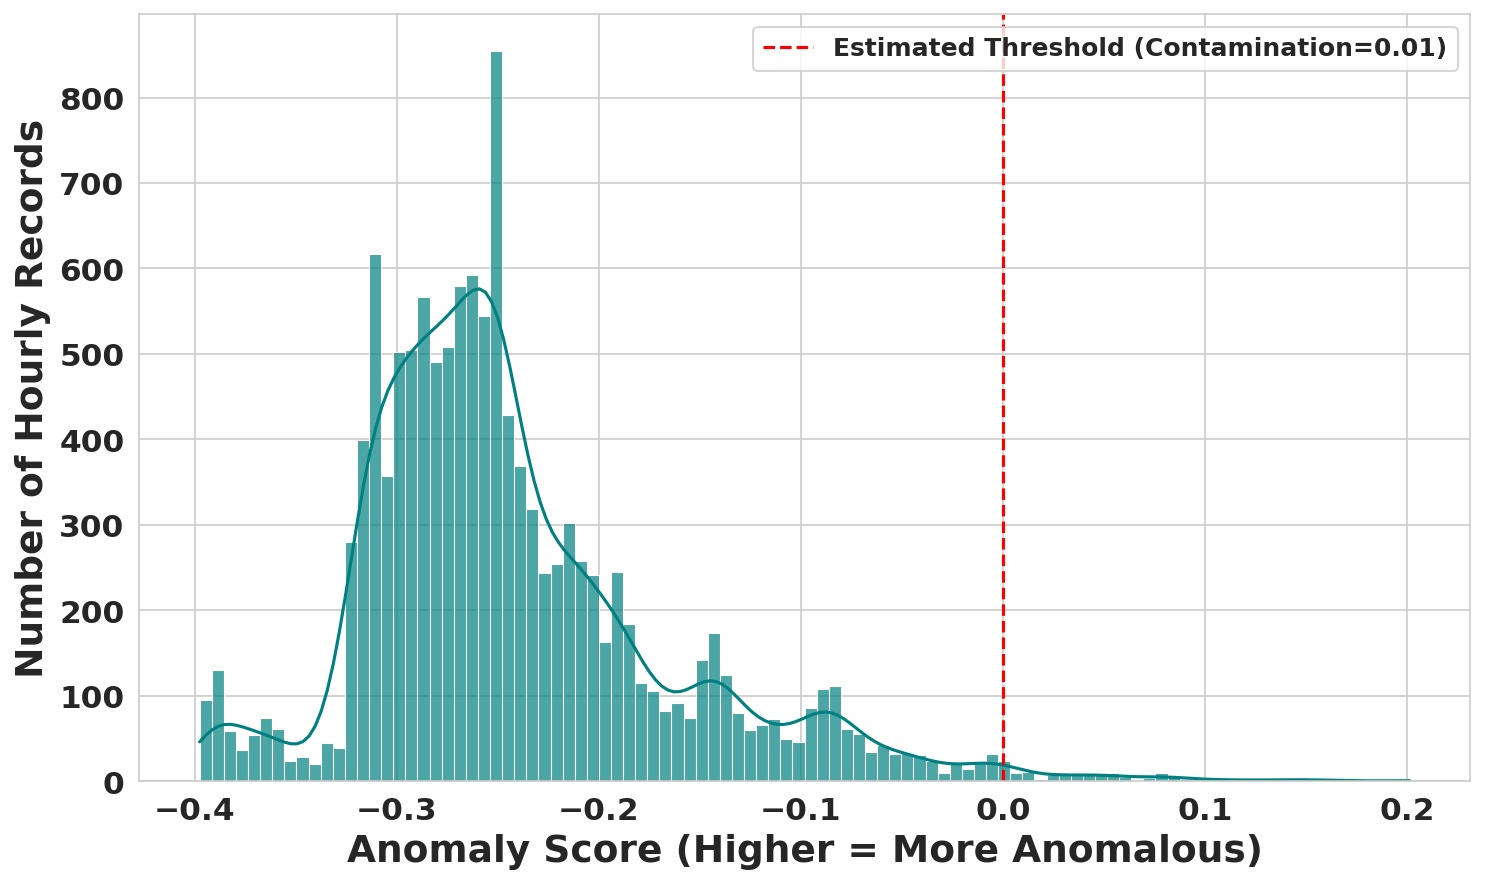

In [8]:

#######################################################################
# 8. Generate Figure 4.5: Anomaly Score Distribution across all Routers#
#    (Run this cell to generate Figure 4.5)                          #
#######################################################################

print("\n--- Generating Anomaly Score Distribution across all Internet2 Routers ---")

# --- Font Size Control Parameters for this specific plot ---
PLOT_4_5_TITLE_FS = 18
PLOT_4_5_LABEL_FS = 18
PLOT_4_5_TICK_FS = 15
PLOT_4_5_LEGEND_FS = 12

if not df_combined_hourly.empty and ANOM_SCORE_COL in df_combined_hourly.columns:
    # Estimate the threshold from the combined data for plotting purposes
    IF_CONTAMINATION_GLOBAL = 0.01 # Consistent with Notebook 1's default
    
    sorted_scores = np.sort(df_combined_hourly[ANOM_SCORE_COL].values)
    if sorted_scores.size > 0:
        threshold_idx = int((1 - IF_CONTAMINATION_GLOBAL) * len(sorted_scores))
        threshold_idx = min(threshold_idx, len(sorted_scores) - 1) 
        threshold_score = sorted_scores[threshold_idx]
    else:
        threshold_score = 0.0 

    plt.figure(figsize=(10, 6))
    ax = plt.gca() # Get current axes for tick formatting
    
    sns.histplot(df_combined_hourly[ANOM_SCORE_COL], bins=100, kde=True, color='teal', alpha=0.7, ax=ax)
    plt.axvline(x=threshold_score, color='red', linestyle='--', label=f'Estimated Threshold (Contamination={IF_CONTAMINATION_GLOBAL})')
    
    # plt.title(f"Isolation Forest Anomaly Score Histogram (All Routers)", fontsize=PLOT_4_5_TITLE_FS)
    plt.xlabel("Anomaly Score (Higher = More Anomalous)", fontsize=PLOT_4_5_LABEL_FS, fontweight='bold')
    plt.ylabel("Number of Hourly Records", fontsize=PLOT_4_5_LABEL_FS, fontweight='bold')
    
    plt.xticks(fontsize=PLOT_4_5_TICK_FS)
    plt.yticks(fontsize=PLOT_4_5_TICK_FS)
    
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight('bold')
    
    # Apply custom scientific formatter to y-axis (count) if needed
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(custom_scientific_formatter))
    
    # Define FontProperties for the legend labels
    legend_label_font = fm.FontProperties(size=PLOT_4_5_LEGEND_FS, weight='bold') # Apply bold directly to labels

    # Get legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # Create legend, setting font properties for labels. No title for this legend.
    ax.legend(handles=handles, labels=labels, 
              prop=legend_label_font, # Use prop for font properties of the labels
              frameon=True)

    save_and_display_plot(f"ch4_fig3a_score_histogram", router_label="")
else:
    print(f"  No combined hourly data or '{ANOM_SCORE_COL}' column to plot Figure 4.5. Skipping.")




--- Generating Dallas Router Traffic Time Series with Detected Anomalies ---
  Saved ch4_fig3b_dallas_traffic_anomalies.png and ch4_fig3b_dallas_traffic_anomalies.pdf


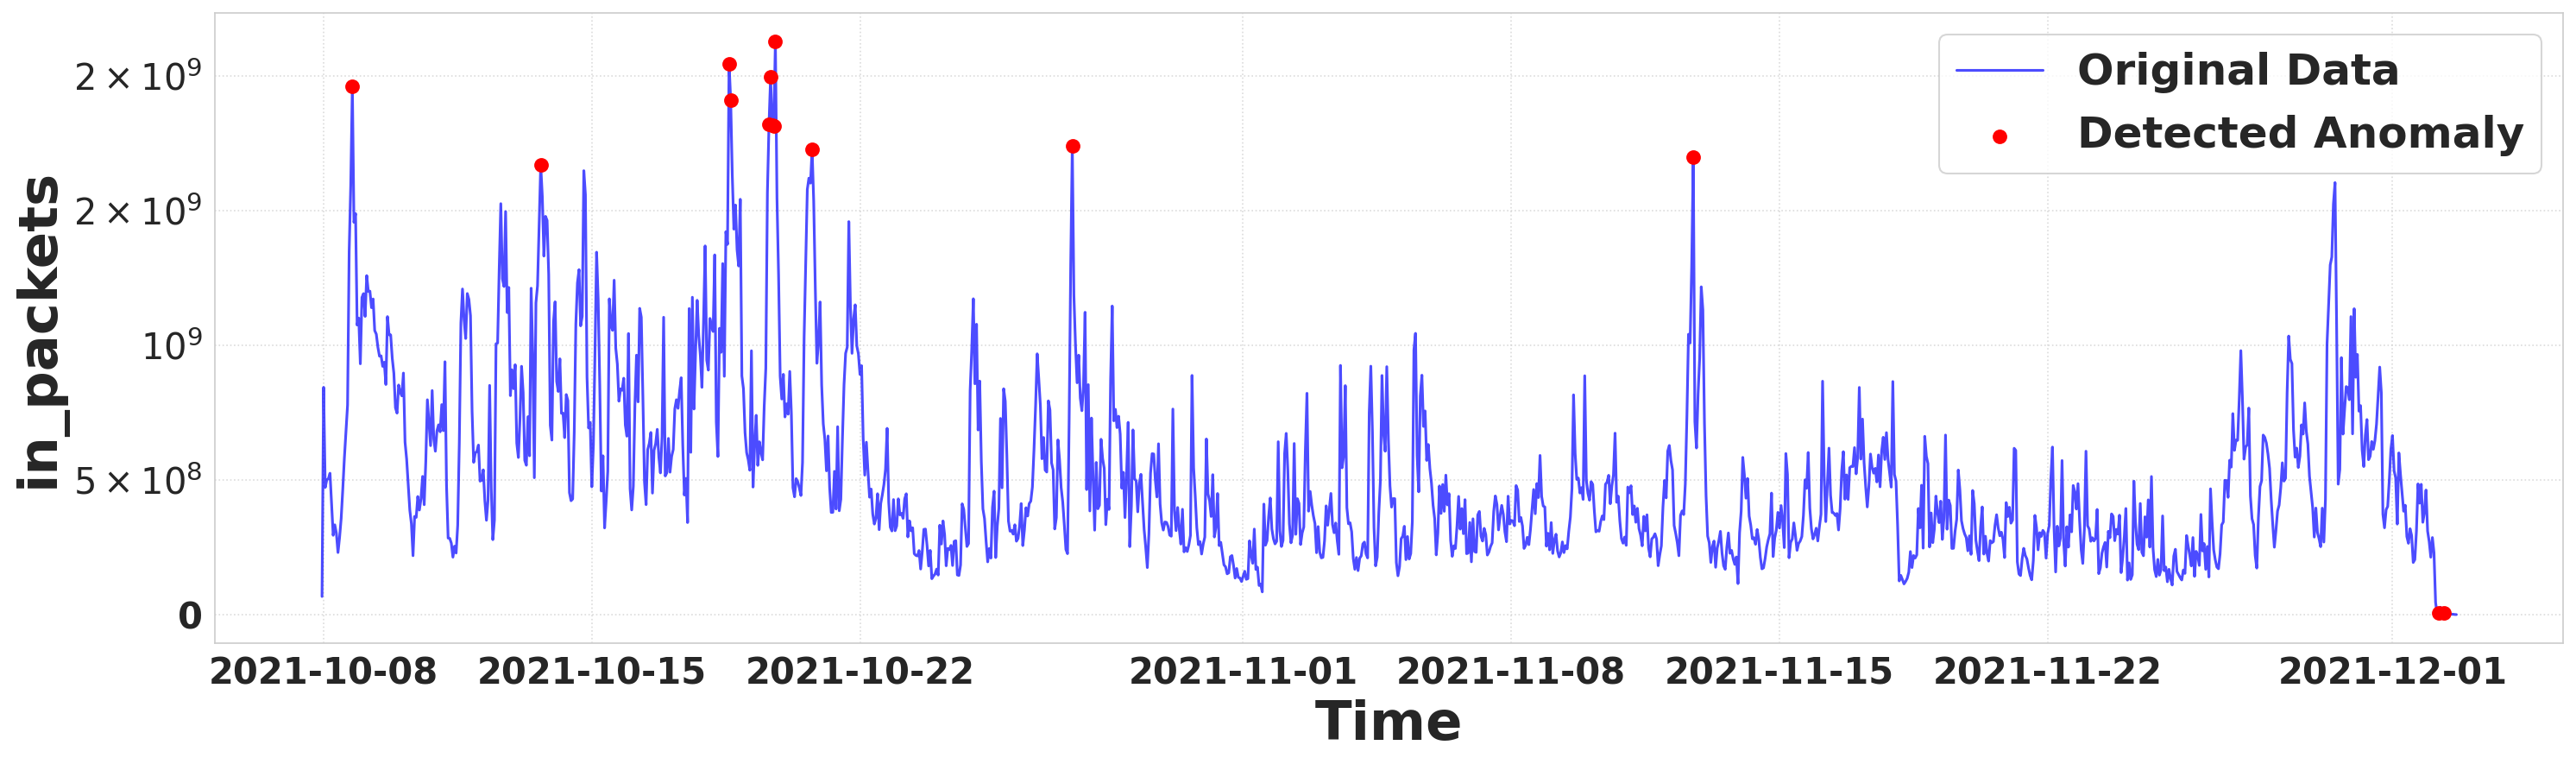


--- Notebook: Chapter 4 EDA & Anomaly Plots Complete ---
All generated figures are saved in: /home/ramamurthy/mhnarfth/network_analysis/individually process kora/outputs/ch4/figs/eda


In [9]:

#######################################################################
# 9. Generate Figure 4.6: Dallas Router Traffic with Detected Anomalies#
#    (Run this cell to generate Figure 4.6)                          #
#######################################################################

print("\n--- Generating Dallas Router Traffic Time Series with Detected Anomalies ---")

# --- Font Size Control Parameters for this specific plot ---
PLOT_4_6_TITLE_FS = 18
PLOT_4_6_LABEL_FS = 30
PLOT_4_6_TICK_FS = 20
PLOT_4_6_LEGEND_FS = 24

dallas_df = df_combined_hourly[df_combined_hourly[ROUTER_COL] == 'jacksonville'].copy()

if not dallas_df.empty and ANOM_FLAG_COL in dallas_df.columns:
    plt.figure(figsize=(20, 6))
    ax = plt.gca() # Get current axes for tick formatting

    plt.plot(dallas_df.index, dallas_df[TARGET_COL], label='Original Data', color='blue', alpha=0.7)
    anomalies = dallas_df[dallas_df[ANOM_FLAG_COL] == 1]
    plt.scatter(anomalies.index, anomalies[TARGET_COL], color='red', s=50, label='Detected Anomaly', zorder=5)
    
    # plt.title(f"Dallas Router {TARGET_COL} Time Series with Detected Anomalies", fontsize=PLOT_4_6_TITLE_FS)
    plt.xlabel("Time", fontsize=PLOT_4_6_LABEL_FS, fontweight='bold')
    plt.ylabel(f"{TARGET_COL}", fontsize=PLOT_4_6_LABEL_FS, fontweight='bold')
    
    plt.xticks(fontsize=PLOT_4_6_TICK_FS, fontweight='bold')
    plt.yticks(fontsize=PLOT_4_6_TICK_FS, fontweight='bold')
    
    # Apply custom scientific formatter to y-axis for large numbers
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(custom_scientific_formatter))

    # Define FontProperties for the legend labels
    legend_label_font = fm.FontProperties(size=PLOT_4_6_LEGEND_FS, weight='bold')

    # Get legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # Create legend, setting font properties for labels. No title for this legend.
    ax.legend(handles=handles, labels=labels, 
              prop=legend_label_font, # Use prop for font properties of the labels
              frameon=True)

    plt.grid(True, linestyle=':', alpha=0.7)
    save_and_display_plot(f"ch4_fig3b_dallas_traffic_anomalies", router_label="")
else:
    print("  No data found for Dallas router or anomaly flags to plot Figure 4.6. Skipping.")


#######################################################################
# END OF NOTEBOOK                                                     #
#######################################################################
print("\n--- Notebook: Chapter 4 EDA & Anomaly Plots Complete ---")
print(f"All generated figures are saved in: {FIG_DIR}")

# --- END OF FILE chapter4_eda_anomaly_plots.py ---


--- Generating Dallas Router Traffic Time Series with Detected Anomalies ---
  Saved ch4_fig3c_elpaso_traffic_anomalies.png and ch4_fig3c_elpaso_traffic_anomalies.pdf


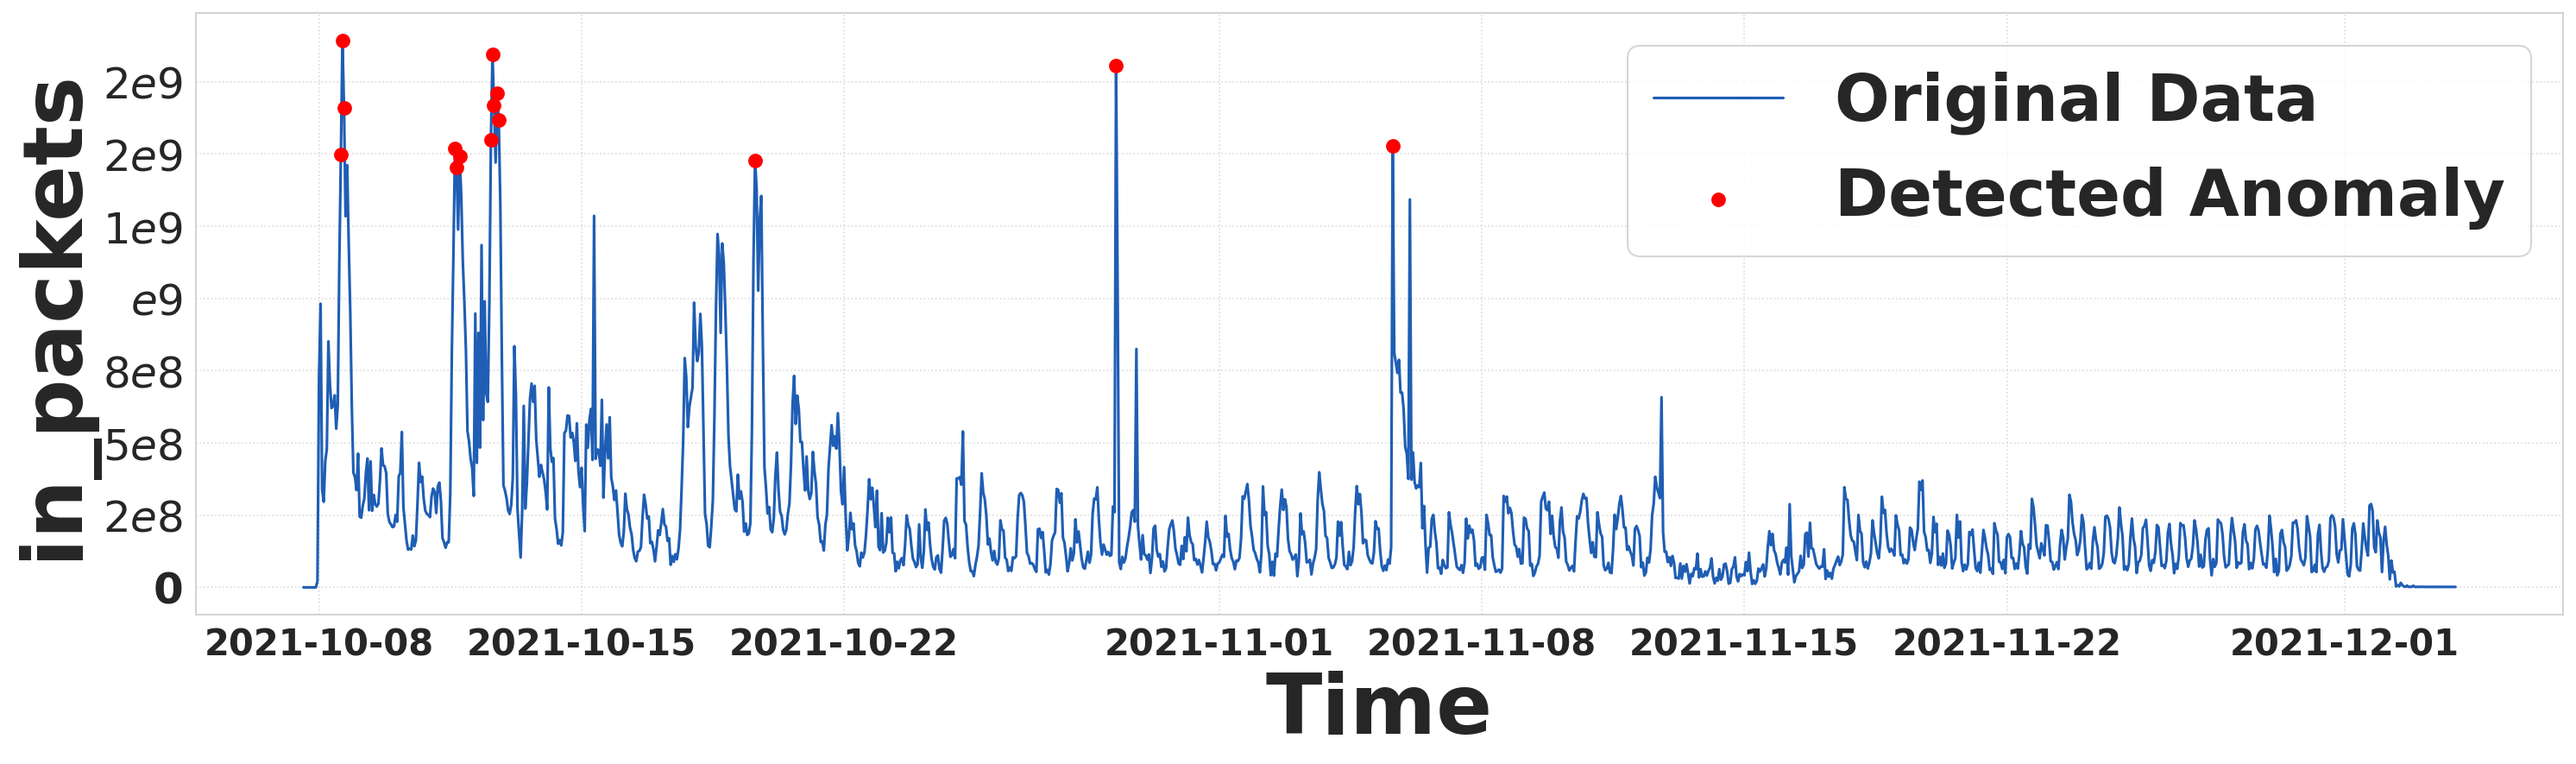


--- Notebook: Chapter 4 EDA & Anomaly Plots Complete ---
All generated figures are saved in: /home/ramamurthy/mhnarfth/network_analysis/individually process kora/outputs/ch4/figs/eda


In [45]:
#######################################################################
# 9. Generate Figure 4.6: Dallas Router Traffic with Detected Anomalies#
#    (Run this cell to generate Figure 4.6)                           #
#######################################################################

print("\n--- Generating Dallas Router Traffic Time Series with Detected Anomalies ---")

# --- Font Size Control Parameters for this specific plot ---
PLOT_4_6_TITLE_FS = 18
PLOT_4_6_LABEL_FS = 46
PLOT_4_6_X_TICK_FS = 20
PLOT_4_6_Y_TICK_FS = 24
PLOT_4_6_LEGEND_FS = 36

dallas_df = df_combined_hourly[df_combined_hourly[ROUTER_COL] == 'elpaso'].copy()

if not dallas_df.empty and ANOM_FLAG_COL in dallas_df.columns:
    plt.figure(figsize=(20, 6))
    ax = plt.gca() # Get current axes for tick formatting

    # Changed the line color to 'blue'
    plt.plot(dallas_df.index, dallas_df[TARGET_COL], label='Original Data', color='#1f5eb4', alpha=1)
    anomalies = dallas_df[dallas_df[ANOM_FLAG_COL] == 1]
    plt.scatter(anomalies.index, anomalies[TARGET_COL], color='red', s=50, label='Detected Anomaly', zorder=5)
    
    # plt.title(f"Dallas Router {TARGET_COL} Time Series with Detected Anomalies", fontsize=PLOT_4_6_TITLE_FS)
    plt.xlabel("Time", fontsize=PLOT_4_6_LABEL_FS, fontweight='bold')
    plt.ylabel(f"{TARGET_COL}", fontsize=PLOT_4_6_LABEL_FS, fontweight='bold')
    
    # Set different font sizes and bold for x and y ticks
    plt.xticks(fontsize=PLOT_4_6_X_TICK_FS, fontweight='bold')
    plt.yticks(fontsize=PLOT_4_6_Y_TICK_FS, fontweight='bold')
    
    # Apply custom scientific formatter to y-axis for large numbers
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(custom_scientific_formatter))

    # Define FontProperties for the legend labels
    legend_label_font = fm.FontProperties(size=PLOT_4_6_LEGEND_FS, weight='bold')

    # Get legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # Create legend, setting font properties for labels. No title for this legend.
    ax.legend(handles=handles, labels=labels, 
              prop=legend_label_font, # Use prop for font properties of the labels
              frameon=True)

    plt.grid(True, linestyle=':', alpha=0.7)
    save_and_display_plot(f"ch4_fig3c_elpaso_traffic_anomalies", router_label="")
else:
    print("  No data found for Dallas router or anomaly flags to plot Figure 4.6. Skipping.")


#######################################################################
# END OF NOTEBOOK                                                     #
#######################################################################
print("\n--- Notebook: Chapter 4 EDA & Anomaly Plots Complete ---")
print(f"All generated figures are saved in: {FIG_DIR}")

# --- END OF FILE chapter4_eda_anomaly_plots.py ---

In [11]:
# --- START OF FILE calculate_raw_flow_counts.py ---

#######################################################################
# 0. Environment set‑up & Configuration                               #
#######################################################################
# This script calculates the total number of flows (rows) and total packet count
# for each raw router Parquet file and displays them in a table.
#
# IMPORTANT: When pasting into a Jupyter cell, ensure all indentation
# is consistent (e.g., all spaces, no mixed tabs/spaces).
#
# Ensure you have the necessary packages installed:
# !pip install --quiet pandas pyarrow dask[dataframe] tqdm

import os
import warnings
from pathlib import Path

import pandas as pd
import dask.dataframe as dd # For lazy loading and out-of-core processing
from tqdm.auto import tqdm # For progress bars

# Explicitly import display for rich Jupyter output (for tables)
from IPython.display import display

# Suppress minor warnings for cleaner output
warnings.filterwarnings("ignore")

print("Environment setup complete.")

# --- Configuration ---
# Input: Directory containing your RAW router Parquet files
# This path is specific to where your original, un-aggregated router Parquet files are located.
INPUT_RAW_ROUTERS_DIR = Path("/mnt/nrdstor/ramamurthy/mhnarfth/internet2/parquet")

# Define the column that contains packet counts in the raw data
RAW_PACKET_COUNT_COL = "in_packets" # Assuming this is the correct column name

print(f"Configuration loaded. Reading raw router Parquet files from: {INPUT_RAW_ROUTERS_DIR}")

#######################################################################
# 1. Calculate Raw Flow and Packet Counts per Router                  #
#    (Run this cell to load data and compute counts)                  #
#######################################################################

print("\n--- Calculating Raw Flow Counts (in Millions) and Packet Counts (in Billions) for Each Router ---")

# Get a list of all raw router Parquet file paths
all_raw_router_files = sorted(list(INPUT_RAW_ROUTERS_DIR.glob("*.parquet")))

if not all_raw_router_files:
    print(f"Error: No .parquet files found in {INPUT_RAW_ROUTERS_DIR}. Please check the path.")
else:
    flow_counts_data = []

    # Iterate through each raw router file
    for file_path in tqdm(all_raw_router_files, desc="Counting flows and packets per router"):
        router_id = file_path.stem # Extract router name from filename (e.g., "atlanta")
        
        print(f"  Processing {router_id}...")
        try:
            # Lazy-load the Parquet file with Dask, selecting only necessary columns
            ddf_raw = dd.read_parquet(file_path, engine="pyarrow", columns=[RAW_PACKET_COUNT_COL])
            
            # Compute the number of rows (flows)
            num_flows = ddf_raw.shape[0].compute()
            num_flows_millions = num_flows / 1_000_000 # Convert to millions
            
            # Compute the sum of packets
            total_packets = ddf_raw[RAW_PACKET_COUNT_COL].sum().compute()
            total_packets_billions = total_packets / 1_000_000_000 # Convert to billions (10^9)
            
            flow_counts_data.append({
                "Router ID": router_id,
                "# Flows (Millions)": num_flows_millions,
                "# Packets (Billions)": total_packets_billions
            })
            print(f"  {router_id}: {num_flows_millions:.2f} M flows, {total_packets_billions:.2f} B packets.")

        except Exception as e:
            print(f"  Error processing {router_id} ({file_path.name}): {e}. Skipping this router.")
            # Append N/A if there was an error processing the file
            flow_counts_data.append({
                "Router ID": router_id,
                "# Flows (Millions)": "N/A",
                "# Packets (Billions)": "N/A"
            })
            continue

    # Create a Pandas DataFrame from the collected data
    df_raw_flow_counts = pd.DataFrame(flow_counts_data)
    
    # Display the DataFrame (for rich output in Jupyter)
    print("\n--- Table: Raw Flow and Packet Counts per Router ---")
    
    if not df_raw_flow_counts.empty:
        # Check if any 'N/A' values exist, then decide on rounding.
        # Ensure that only numerical columns are rounded if 'N/A' is present.
        # Create a copy to avoid SettingWithCopyWarning if mixed types occur
        df_display = df_raw_flow_counts.copy()
        
        # Determine columns that can be rounded
        cols_to_round = [col for col in df_display.columns if col in ["# Flows (Millions)", "# Packets (Billions)"] and df_display[col].apply(lambda x: isinstance(x, (int, float))).all()]
        
        if cols_to_round:
            df_display[cols_to_round] = df_display[cols_to_round].round(2)
        
        display(df_display)
    else:
        print("  No raw flow or packet counts were successfully calculated to display.")

#######################################################################
# END OF SCRIPT                                                       #
#######################################################################
print("\n--- Raw Flow Count Calculation Complete ---")

# --- END OF FILE calculate_raw_flow_counts.py ---

Environment setup complete.
Configuration loaded. Reading raw router Parquet files from: /mnt/nrdstor/ramamurthy/mhnarfth/internet2/parquet

--- Calculating Raw Flow Counts (in Millions) and Packet Counts (in Billions) for Each Router ---


Counting flows and packets per router:   0%|          | 0/10 [00:00<?, ?it/s]

  Processing atlanta...


Counting flows and packets per router:  10%|█         | 1/10 [00:01<00:09,  1.06s/it]

  atlanta: 28.03 M flows, 610.87 B packets.
  Processing batonrouge...


Counting flows and packets per router:  30%|███       | 3/10 [00:05<00:12,  1.76s/it]

  batonrouge: 80.06 M flows, 1294.36 B packets.
  Processing boston...
  boston: 0.39 M flows, 19.47 B packets.
  Processing dallas...


Counting flows and packets per router:  40%|████      | 4/10 [00:13<00:24,  4.16s/it]

  dallas: 149.78 M flows, 2422.78 B packets.
  Processing elpaso...


Counting flows and packets per router:  50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

  elpaso: 9.36 M flows, 321.45 B packets.
  Processing jackson...


Counting flows and packets per router:  60%|██████    | 6/10 [00:15<00:09,  2.28s/it]

  jackson: 13.40 M flows, 232.67 B packets.
  Processing jacksonville...


Counting flows and packets per router:  80%|████████  | 8/10 [00:17<00:03,  1.51s/it]

  jacksonville: 19.43 M flows, 698.29 B packets.
  Processing louisville...
  louisville: 3.15 M flows, 280.80 B packets.
  Processing phoenix...


Counting flows and packets per router:  90%|█████████ | 9/10 [00:18<00:01,  1.28s/it]

  phoenix: 8.77 M flows, 274.27 B packets.
  Processing reno...


Counting flows and packets per router: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]

  reno: 35.50 M flows, 470.52 B packets.

--- Table: Raw Flow and Packet Counts per Router ---


,Router ID,# Flows (Millions),# Packets (Billions)
0,atlanta,28.03,610.87
1,batonrouge,80.06,1294.36
2,boston,0.39,19.47
3,dallas,149.78,2422.78
4,elpaso,9.36,321.45
5,jackson,13.40,232.67
6,jacksonville,19.43,698.29
7,louisville,3.15,280.80
8,phoenix,8.77,274.27
9,reno,35.50,470.52



--- Raw Flow Count Calculation Complete ---
